# Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import walk

# Loading files

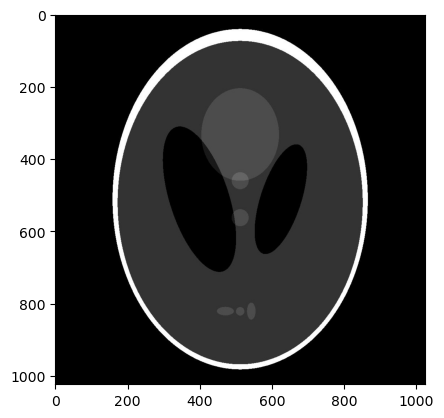

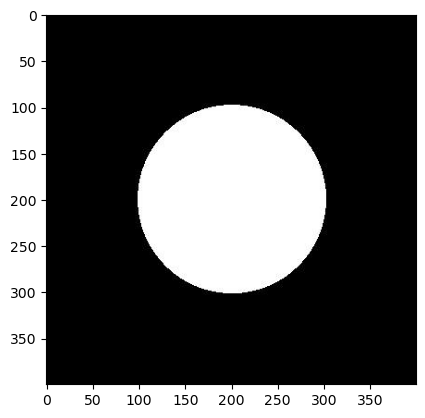

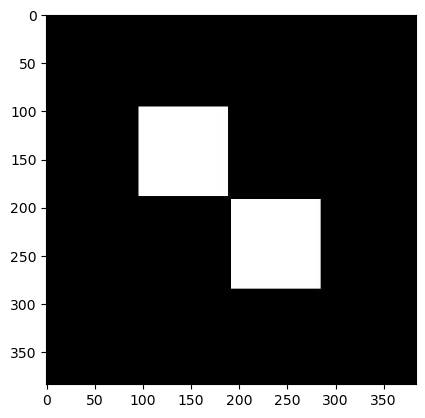

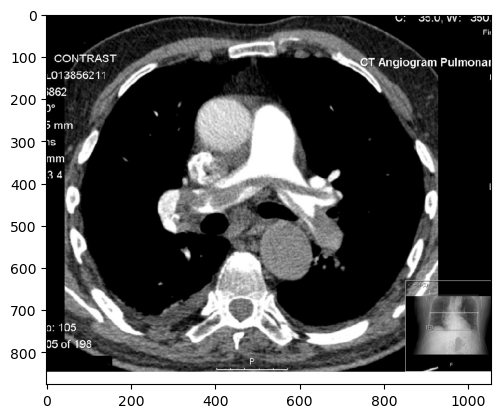

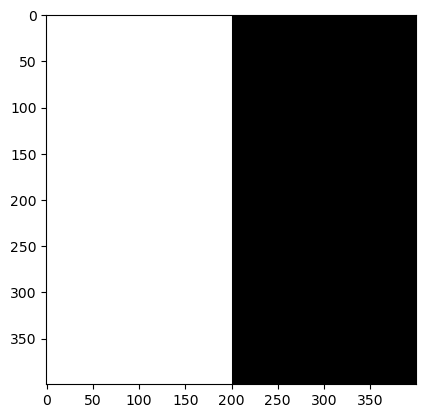

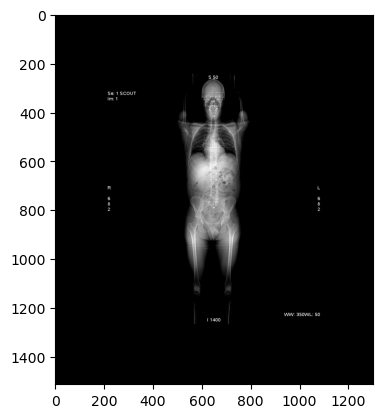

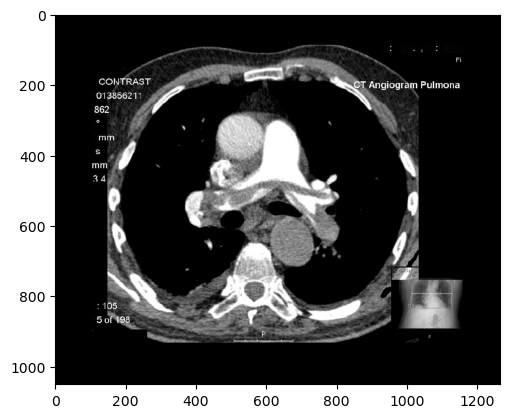

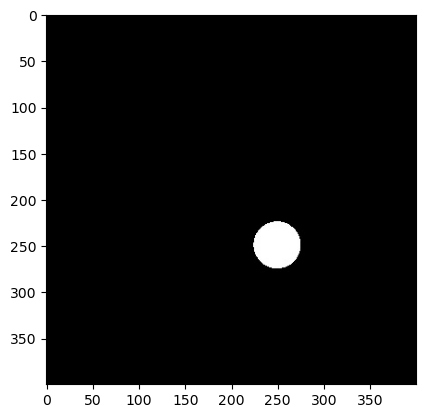

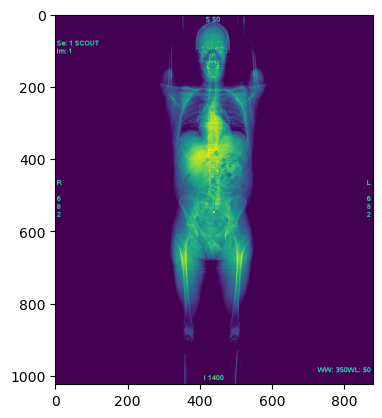

In [3]:
pic_dir = "./tomograf-zdjecia/"
filenames = next(walk(pic_dir), (None, None, []))[2]  # [] if no file

for file in filenames:
    img = mpimg.imread(pic_dir+file)
    # plt.imshow(img)
    # plt.show()